In [1]:
import os 
os.chdir('/lustre/scratch/kiviaho/hillock_club_senescence/')

import scanpy as sc
import numpy as np
import pandas as pd
import squidpy as sq
import anndata as ad

# Bivariate spatial metrics
import liana as li

from upsetplot import from_contents
from upsetplot import UpSet
from venny4py.venny4py import *


from itertools import combinations

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tqdm import tqdm
from utils import get_sample_ids_reorder, get_sample_crop_coords, get_sample_id_mask, load_from_pickle, get_treatment_info

samples = get_sample_ids_reorder()
sample_crop_coord = get_sample_crop_coords()
sample_id_masks = get_sample_id_mask()

import seaborn as sns
sns.set_theme(style='white',font_scale=0.7)

from scipy.stats import ranksums, wilcoxon, fisher_exact, ttest_ind, zscore, spearmanr, pearsonr

import warnings
warnings.filterwarnings("ignore")

region_colors_dict = {
 'Tumor': '#fc8d62',
 'Luminal epithelium': '#8da0cb',
 'Basal epithelium': '#66c2a5',
 'Club epithelium': '#ffd92f',
 'Immune': '#a6d854',
 'Endothelium': '#e78ac3',
 'Fibroblast': '#e5c494',
 'Muscle': '#b3b3b3'
 }

plot_save_path = '/lustre/scratch/kiviaho/hillock_club_senescence/plots/'

# Load gene modules
gene_modules = pd.read_excel('./gene_modules.xlsx')
gene_modules = gene_modules.drop(columns='BPECT Neuroendocrine Identity')
gene_modules_dict = gene_modules.drop(columns=['RANK']).to_dict('list')
for k in gene_modules_dict:
    gene_modules_dict[k] = [g for g in gene_modules_dict[k] if str(g) != 'nan']


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-p7ack_1z because the default path (/run/cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Download data

In [2]:
samples = list(sample_id_masks.keys())

scanpy_res = pd.read_csv('./data/spatial_scanpy_score_results_february2025.csv',index_col=1).drop(columns=['Unnamed: 0'])
obs_data = pd.read_csv('../prostate_spatial/data/pathology_filtered_obs_with_regions.csv',index_col=0)

if (obs_data.index == scanpy_res.index).all():
    obs_data = pd.concat([obs_data,scanpy_res],axis=1)

obs_data['predicted_region'] = pd.Categorical(obs_data['predicted_region'],categories = list(region_colors_dict.keys()))
obs_data['sample_class'] = pd.Categorical(obs_data['sample_class'],categories = ['BPH','TRNA','NEADT','CRPC'])

score_names = scanpy_res.columns.tolist()
obs_data_zscored = obs_data.copy()
obs_data_zscored[score_names] = zscore(obs_data_zscored[score_names],axis=0)

gene_signature_names = list(gene_modules_dict.keys())
obs_data_orig = obs_data.copy()


## Use individual slides for bivariate spatial correlation

In [3]:
# create a signature - signature resource
signatures_for_analysis = [
                'BPECT Luminal Identity','BPECT Basal Identity', 'BPECT Club Identity', 'BPECT Hillock Identity', # BPECTs
                'PMN-MDSC activity','MDSC Hirz 2023','MDSC Calcinotto 2018','High NLR-associated',
                'PDAC IL1B+ Macrophages','PMN-MDSC activity','MDSC Hirz 2023', 'PDAC scRNAseq Neutrophils', 'MHCII', # Myeloid activity
                'HALLMARK_INTERFERON_ALPHA_RESPONSE', 'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'MHCI', # Immune-related
                'PDAC T1RS Caronni et al. 2023','Lung KACs Han et al. 2024','JAK_STAT_FGFR'

                           
                           
                           ]
#combs = list(combinations(signatures_for_analysis,2))
combs = list(combinations(gene_signature_names,2)) # Take all the signatures for the analysis
gene_signatures_for_resource = pd.DataFrame({
    'ligand' : [s[0] for s in combs],
    'receptor': [s[1] for s in combs]
})


### Calculate bivariate Moran's I for different BPECTs

In [4]:
lrdata_dict = {}
spatial_corr_results_dict = {}

for sample in tqdm(samples,desc='sample'): 
#    sample = samples[14]
        
    slide = sc.read_h5ad(f'../prostate_spatial/data/visium_with_regions/{sample}_with_regions.h5ad')

    # Add the scores to slide object
    slide.obs = pd.merge(slide.obs,scanpy_res,left_index=True,right_index=True)

    dat = ad.AnnData(
        X = slide.obs[gene_signature_names],
        var = pd.DataFrame(index = gene_signature_names),
        obs = slide.obs
    )

    dat.uns = slide.uns.copy()
    dat.obsm = slide.obsm.copy()
    dat.obsp = slide.obsp.copy()

    li.ut.spatial_neighbors(dat, bandwidth=300, cutoff=0.1, kernel='gaussian', set_diag=True)
    #li.pl.connectivity(dat, idx=0, size=1.3)

    lrdata = li.mt.bivariate(dat,
                    resource = gene_signatures_for_resource, # NOTE: A pairwise combination of signatures
                    local_name='cosine', # Name of the function
                    global_name="morans", # Name global function                    
                    n_perms=1, # Number of permutations to calculate a p-value          ----> No need for a p-value
                    mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
                    add_categories=True, # Whether to add local categories to the results
                    nz_prop=0, # Minimum expr. proportion for ligands/receptors and their subunits
                    use_raw=False,
                    verbose=False
                    )

    var_df = lrdata.var.copy()
    
    lrdata_dict[sample] = lrdata

    # Save the results into a dict
    spatial_corr_results_dict[sample] = var_df

# Concatenate the results
res_df = pd.concat(spatial_corr_results_dict)
res_df = res_df.rename(columns={'ligand' : 'Identity score'})

sample: 100%|██████████| 48/48 [01:25<00:00,  1.78s/it]


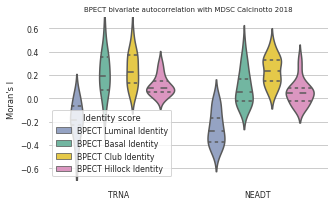

TRNA
BPECT Luminal Identity vs BPECT Basal Identity: 3.6e-06 ***
BPECT Luminal Identity vs BPECT Club Identity: 6.5e-07 ***
BPECT Luminal Identity vs BPECT Hillock Identity: 1.3e-06 ***
BPECT Basal Identity vs BPECT Club Identity: 0.55
BPECT Basal Identity vs BPECT Hillock Identity: 0.06
BPECT Club Identity vs BPECT Hillock Identity: 4.0e-03 **

NEADT
BPECT Luminal Identity vs BPECT Basal Identity: 2.1e-07 ***
BPECT Luminal Identity vs BPECT Club Identity: 1.3e-08 ***
BPECT Luminal Identity vs BPECT Hillock Identity: 2.4e-07 ***
BPECT Basal Identity vs BPECT Club Identity: 1.8e-03 **
BPECT Basal Identity vs BPECT Hillock Identity: 0.47
BPECT Club Identity vs BPECT Hillock Identity: 1.4e-05 ***



In [5]:
pal = sns.color_palette('Set2')
sns.set_theme(style='whitegrid', palette = sns.color_palette([pal[2], pal[0],pal[5],pal[3]]),font_scale=0.7)

bpect_signature_names = ['BPECT Luminal Identity','BPECT Basal Identity', 'BPECT Club Identity', 'BPECT Hillock Identity']

var = 'MDSC Calcinotto 2018'
metric = 'morans'

fig, ax = plt.subplots(1,1,figsize=(5,3))

plot_df = res_df[(res_df['Identity score'].isin(bpect_signature_names)) & (res_df['receptor'].isin([var]))]

plot_df = plot_df.reset_index().rename(columns={'level_0':'patient'})
plot_df['sample_category'] = [s.split(' ')[0] for s in plot_df['patient'].map(get_sample_id_mask())]

plot_df = plot_df[plot_df['sample_category'].isin(['TRNA','NEADT'])]

#sns.boxplot(data=plot_df, x='sample_category', y=metric, hue = 'Identity score', fliersize=1, ax = ax)
sns.violinplot(data=plot_df, x='sample_category', y=metric, hue = 'Identity score', inner='quart', fill=True, ax = ax)

ax.set_xlabel('')
ax.set_title(f'BPECT bivariate autocorrelation with {var}',fontdict={'size':7})
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.set_ylim(-1,1)
ax.set_ylabel("Moran's I")
ax.set_ylim(plot_df[metric].min() * 1.2, plot_df[metric].max() * 1.2)

#plt.savefig('./plots/tmp/violin.pdf')

plt.show()

# PRINT p-value differences

for sample_cat in ['TRNA', 'NEADT']:
    print(sample_cat)
    df = plot_df[plot_df['sample_category'] == sample_cat]
    for grp1, grp2 in list(combinations(df['Identity score'].unique(),2)):
        stat, pval = ranksums(df[df['Identity score'] == grp1][metric],
                                df[df['Identity score'] == grp2][metric])

        if pval < 0.001:
            print(f'{grp1} vs {grp2}: {pval:.1e} ***')
        
        elif pval < 0.01:
            print(f'{grp1} vs {grp2}: {pval:.1e} **')
        
        elif pval < 0.05:
            print(f'{grp1} vs {grp2}: {pval:.1e} *')
        
        elif pval >= 0.05:
            print(f'{grp1} vs {grp2}: {pval:.2f}')
    print('')

In [85]:

combs = list(combinations(['BPECT Club Identity','MDSC Calcinotto 2018','PDAC IL1B+ Macrophages'],2))

for tup1,tup2 in combs:
    set1 = set(gene_modules_dict[tup1])
    set2 = set(gene_modules_dict[tup2])

    overlap = set1.intersection(set2)
    a = len(overlap)
    b = len(set1) - a 
    c = len(set2) - a
    d = 15000 - a - b - c

    arr = np.array([[a,b],[c,d]])
    stat, pval = fisher_exact(arr)

    if pval < 1e-3:
        print (f'{tup1} - {tup2} overlap: p = {pval:.1e}')
    else:
        print (f'{tup1} - {tup2} overlap: p = {pval:.2f}')
    print(overlap)

BPECT Club Identity - MDSC Calcinotto 2018 overlap: p = 0.22
{'CXCL6'}
BPECT Club Identity - PDAC IL1B+ Macrophages overlap: p = 0.17
{'FCGBP'}
MDSC Calcinotto 2018 - PDAC IL1B+ Macrophages overlap: p = 3.0e-10
{'IL10', 'IL1B', 'IL6', 'IL1R2', 'IL1A', 'CCL20', 'CCL4L2', 'CCL3', 'CCL4'}


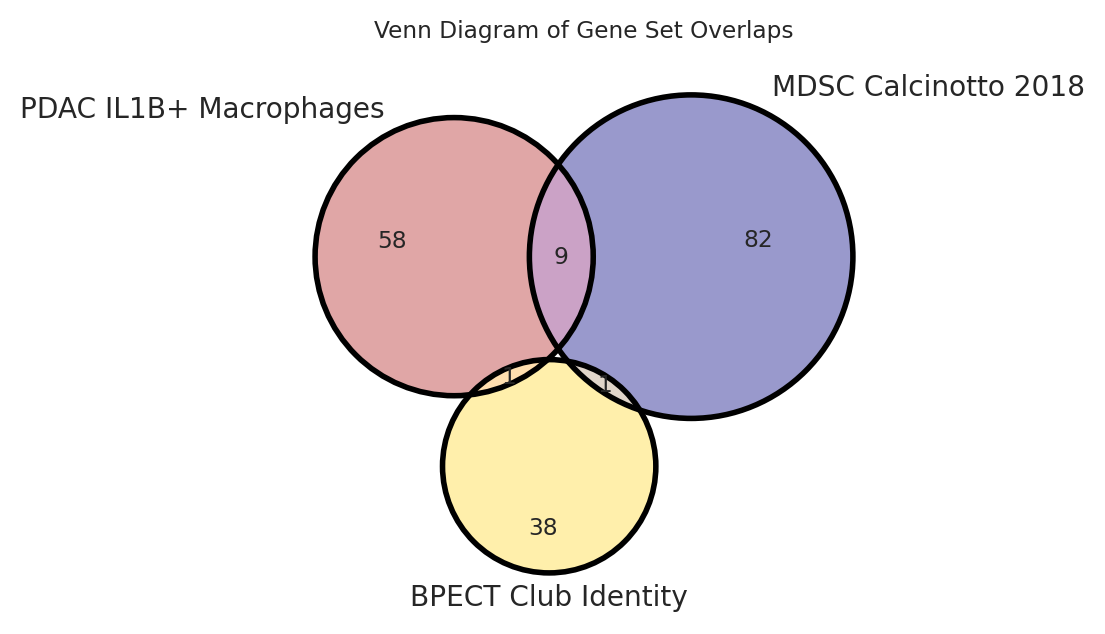

In [55]:
sns.set_theme(style='white', font_scale=0.7, palette='Accent')
sets_dict = {
    'PDAC IL1B+ Macrophages': set(gene_modules_dict['PDAC IL1B+ Macrophages']),
    'MDSC Calcinotto 2018': set(gene_modules_dict['MDSC Calcinotto 2018']),
    'BPECT Club Identity': set(gene_modules_dict['BPECT Club Identity']),
}

from matplotlib_venn import venn3, venn3_circles
# Plot Venn diagram
plt.figure(figsize=(4, 4))
venn3(list(sets_dict.values()), list(sets_dict.keys()),set_colors=('firebrick','navy','#ffd92f'))
venn3_circles(list(sets_dict.values()))

plt.title("Venn Diagram of Gene Set Overlaps")
plt.savefig('./plots/tmp/venn.pdf')
plt.show()


### Increment bandwidth to test for it's effect

In [5]:
# Sorted
gene_signatures_for_resource = pd.DataFrame({
    'ligand' : ['BPECT Luminal Identity','BPECT Basal Identity', 'BPECT Club Identity', 'BPECT Hillock Identity'],
    'receptor': list(np.repeat('MDSC Calcinotto 2018',4))
})

bandwidth_range = [110, 190, 220, 280, 290, 320, 370]
approx_neighbors =[6, 12, 18, 27, 30, 36, 42]


In [6]:
def filter_top_scoring_spots(adata, top_idxs, bandwidth_for_neighboring_spots = 110, n_minimum_neighboring_spots=3):
    """
    Filters top scoring spots based on the number of neighboring spots.

    Parameters:
    - dat: Data object containing spatial information.
    - top_idxs: List of indices of top scoring spots.
    - bandwidth_for_neighboring_spots: Bandwidth for filtering (default: first value in bandwidth_range).
    - n_minimum_neighboring_spots: Minimum number of neighboring spots (default: 3).

    Returns:
    - Filtered list of top scoring indices.
    """
    top_scoring_indices_filtered = []

    # Run spatial neighbors to find the immediate neighbors
    li.ut.spatial_neighbors(adata, bandwidth=bandwidth_for_neighboring_spots, cutoff=0.1, kernel='gaussian', set_diag=True)
    connectivity_arr = np.array(adata.obsp['spatial_connectivities'].todense())
    where_tuple = np.where(connectivity_arr[top_idxs, :] != 0)  # Spots neighboring the top-scoring spots

    for idx, top_scoring_idx in enumerate(top_idxs):
        neighbors = where_tuple[1][where_tuple[0] == idx]
        # Find the number of neighbors that are also in top_idxs
        intersection = list(np.intersect1d(neighbors, top_idxs))
        if len(intersection) >= n_minimum_neighboring_spots:
            top_scoring_indices_filtered += intersection  # Add the top scoring and the neighboring ones to the list

    # Only keep the spots that passed the filter
    top_scoring_indices_filtered = set(top_scoring_indices_filtered)

    return list(top_scoring_indices_filtered)


### Compute neighborhood enrichement with increasing neighborhood size

In [10]:

comparison_sig = 'MDSC Calcinotto 2018'
q_thresh = 0.90
filter_by_n_neighboring_spots = True
n_minimum_neighboring_spots = 3 # The minimum number of immediate neighbors for a spot to be considered, NOTE: The spot considers itself a neighbor
bandwidth_for_neighboring_spots = bandwidth_range[0] # The bandwidth parameter to use for filtering out sporadically included spots 0 --> immediate neighbors
bpect_signature_names = ['BPECT Luminal Identity','BPECT Basal Identity', 'BPECT Club Identity', 'BPECT Hillock Identity']

total_res_df = pd.DataFrame()
for sample in tqdm(samples):
    #sample = samples[20]

    sample_res_df = pd.DataFrame()
    slide = sc.read_h5ad(f'../prostate_spatial/data/visium_with_regions/{sample}_with_regions.h5ad')

    # Add the scores to slide object
    slide.obs = pd.merge(slide.obs,scanpy_res,left_index=True,right_index=True)

    dat = ad.AnnData(
        X = slide.obs[gene_signature_names],
        var = pd.DataFrame(index = gene_signature_names),
        obs = slide.obs
    )

    dat.uns = slide.uns.copy()
    dat.obsm = slide.obsm.copy()
    dat.obsp = slide.obsp.copy()

    for sig in bpect_signature_names:

        obs_data = dat.obs.copy().reset_index()

        # Get the indices of spots that are above q thershold for signature 1
        top_scoring_indices = obs_data.loc[(obs_data[sig] > obs_data[sig].quantile(q_thresh))].index
        top_scoring_indices = filter_top_scoring_spots(slide, top_scoring_indices)

        # Do the same filtering to the comparison signature
        top_scoring_comparison_sig_indices = obs_data.loc[(obs_data[comparison_sig] > obs_data[comparison_sig].quantile(q_thresh))].index
        top_scoring_comparison_sig_indices = filter_top_scoring_spots(slide, top_scoring_comparison_sig_indices)

        # Binarize the signature 2 values so that they're v < q0.9 --> 0 and v >= q0.9 --> 1
        obs_data[f'{comparison_sig} binary'] = 0
        obs_data.loc[top_scoring_comparison_sig_indices, f'{comparison_sig} binary'] = 1

        frac_connected = []
        n_spot_neighbors = []
        for i,bwidth in enumerate(bandwidth_range):
            li.ut.spatial_neighbors(dat,bandwidth=bwidth, cutoff=0.1, kernel='gaussian', set_diag=True)
            connectivity_arr = np.array(dat.obsp['spatial_connectivities'].todense())

            # Find the top-scoring spots in the connectivity matrix and 
            # find the indices of the spots that are connected with the current bandwidth parameter
            connected_indices = np.unique(np.where(connectivity_arr[top_scoring_indices,:] != 0)[1])

            # What is the percentage of spots scoring high for "comparison_sig" that are close to spots scoring high for
            # BPECT signatures
            pct_top_scoring_connected = obs_data.loc[connected_indices,f'{comparison_sig} binary'].sum() / len(top_scoring_comparison_sig_indices)

            frac_connected.append(pct_top_scoring_connected)
            n_spot_neighbors.append(approx_neighbors[i])
        df = pd.DataFrame({'Cell_type_identity':np.repeat(sig,len(bandwidth_range)),
                        'fraction_spots': frac_connected,
                        'n_spot_neighbors': n_spot_neighbors
                        })

        sample_res_df = pd.concat([sample_res_df,df],axis=0)

    sample_res_df['sample'] = sample

    total_res_df = pd.concat([total_res_df,sample_res_df])

  0%|          | 0/48 [00:00<?, ?it/s]

100%|██████████| 48/48 [03:39<00:00,  4.58s/it]


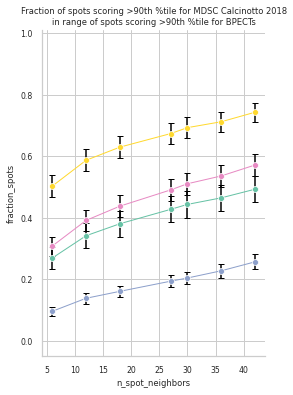

In [20]:
pal = sns.color_palette('Set2')
pal = sns.color_palette([pal[2], pal[0],pal[5],pal[3]])
sns.set_theme(style='whitegrid', palette = pal,font_scale=0.7)

sampletypes = ['BPH','TRNA','NEADT','CRPC'] # 'CRPC'

plot_df = total_res_df.reset_index().copy()
plot_df['sample_category'] = [s.split(' ')[0] for s in plot_df['sample'].map(get_sample_id_mask())]
plot_df = plot_df[plot_df['sample_category'].isin(sampletypes)]

fig, ax = plt.subplots(figsize = (4,6))

df_mean_se = plot_df.groupby(['n_spot_neighbors', 'Cell_type_identity']).agg({'fraction_spots': ['mean', 'sem']}).reset_index()
df_mean_se.columns = ['n_spot_neighbors', 'Cell_type_identity', 'mean_pct_in_sample', 'se_pct_in_sample']

ax.errorbar(df_mean_se['n_spot_neighbors'], df_mean_se['mean_pct_in_sample'], yerr=df_mean_se['se_pct_in_sample'], fmt='none', c='black', capsize=3)
sns.lineplot(data=plot_df,
             x='n_spot_neighbors', 
             y='fraction_spots', 
             hue = 'Cell_type_identity',
             marker='o',
             markersize=6,  # Adjust the size of the markers
             dashes=False,
             legend=False,
             errorbar = None,
             linewidth = 1,
             ax=ax,
            )
ax.set_ylim(-0.05,1.01)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('./plots/tmp/lineplot.pdf')

ax.set_title(f'Fraction of spots scoring >{q_thresh*100:.0f}th %tile for {comparison_sig}\nin range of spots scoring >{q_thresh*100:.0f}th %tile for BPECTs')


plt.show()

### Plot regions on spatial axis

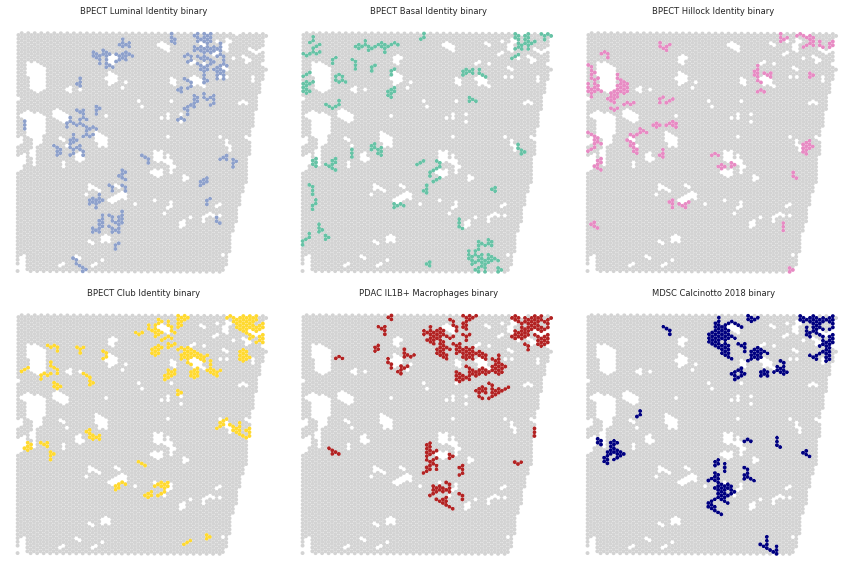

In [21]:
# Extend the palette to 6 colors
std_pal = sns.color_palette('Set2')
pal = sns.color_palette([std_pal[2], std_pal[0],std_pal[3],std_pal[5],'firebrick','navy'])
sns.set_theme(style='whitegrid', palette = pal,font_scale=0.7)

q_thresh = 0.90

# Only take samples that have > 3k spot count
valid_samples = obs_data_orig['sample_id'].value_counts()[obs_data_orig['sample_id'].value_counts() > 4000].index.tolist()

#for sample in valid_samples:
sample = valid_samples[2]

slide = sc.read_h5ad(f'../prostate_spatial/data/visium_with_regions/{sample}_with_regions.h5ad')

# Add the scores to slide object
slide.obs = pd.merge(slide.obs, scanpy_res, left_index=True, right_index=True)

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

lst = ['BPECT Luminal Identity','BPECT Basal Identity','BPECT Hillock Identity','BPECT Club Identity','PDAC IL1B+ Macrophages','MDSC Calcinotto 2018',]
for i, sig in enumerate(lst):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    obs_data = slide.obs.copy().reset_index()

    top_scoring_indices = obs_data.loc[(obs_data[sig] > obs_data[sig].quantile(q_thresh))].index
    top_scoring_indices = filter_top_scoring_spots(slide, top_scoring_indices)
    
    obs_data[f'{sig} binary'] = pd.Categorical(np.repeat('No',len(obs_data)),categories=['No','Yes'])
    obs_data.loc[top_scoring_indices, f'{sig} binary'] = 'Yes'
    slide.obs = obs_data.set_index('index').copy()

    if 'P320' in sample:
        sc.pl.spatial(slide, color=f'{sig} binary', palette=sns.color_palette(['lightgray', pal[i]]),
                        size=1.3, alpha_img=0.5, vmin='p1', vmax='p99', legend_loc=None,
                        ax=ax, show=False, frameon=False)
    else:
        sc.pl.spatial(slide, color=f'{sig} binary', palette=sns.color_palette(['lightgray', pal[i]]),
                        size=1.6, alpha_img=0, vmin='p1', vmax='p99', legend_loc=None,
                        ax=ax, show=False, frameon=False,
                        crop_coord=sample_crop_coord[sample])

plt.savefig('./plots/tmp/spatialplot.pdf')

plt.tight_layout()
plt.show()


### Make a upsetplot of the spots scoring highest for each signature

In [23]:
sample

'PC_06_04581_OIK_POST_0'

In [45]:
q_thresh = 0.90
lst = ['BPECT Luminal Identity','BPECT Basal Identity','BPECT Hillock Identity','BPECT Club Identity','MDSC Calcinotto 2018']

# Prime the dict of barcodes for adding onto
quantile_threshold_passing_spots_dict = {}
for l in lst:
    quantile_threshold_passing_spots_dict[l] = []


for sample in tqdm(samples,unit='sample'):
    slide = sc.read_h5ad(f'../prostate_spatial/data/visium_with_regions/{sample}_with_regions.h5ad')

    # Add the scores to slide object
    slide.obs = pd.merge(slide.obs, scanpy_res, left_index=True, right_index=True)

    for sig in lst:

        obs_data = slide.obs.copy().reset_index()

        # Discard non-connected spots: Default: minimum 2 first-order neighbors 
        top_scoring_indices = obs_data.loc[(obs_data[sig] > obs_data[sig].quantile(q_thresh))].index
        top_scoring_indices_filtered = filter_top_scoring_spots(slide, top_scoring_indices)

        # Extract the spot IDs and add them onto the list
        spot_ids = obs_data.loc[top_scoring_indices_filtered]['index'].tolist() # Barcodes scoring high for this particular gene set
        quantile_threshold_passing_spots_dict[sig] += spot_ids


100%|██████████| 48/48 [00:42<00:00,  1.14sample/s]


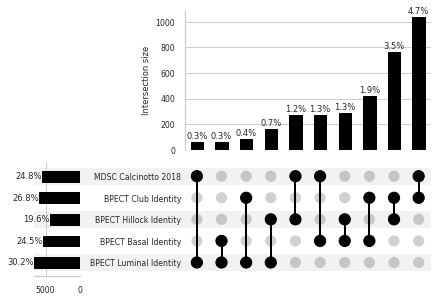

In [49]:

upsetplot_df = from_contents(quantile_threshold_passing_spots_dict)
ax_dict = UpSet(upsetplot_df, subset_size="count",min_degree=2,max_degree=2,show_percentages=True, sort_categories_by='input',sort_by='-cardinality').plot()
plt.savefig('plots/tmp/upsetplot.pdf')

In [72]:
intersect_against = 'BPECT Luminal Identity'
baseline = 'BPECT Club Identity'

n_intersect = len(upsetplot_df.loc[(upsetplot_df.index.get_level_values(baseline) == True) & (upsetplot_df.index.get_level_values(intersect_against) == True)]) 
n_baseline = len(upsetplot_df.loc[(upsetplot_df.index.get_level_values(baseline))])
pct = n_intersect/n_baseline
print(f'{intersect_against}-intersecting out of all {baseline} spots: {pct:.1%}')
 


BPECT Luminal Identity-intersecting out of all BPECT Club Identity spots: 2.7%


In [ ]:

plot_df = plot_df.reset_index().rename(columns={'level_0':'patient'})
plot_df['sample_category'] = [s.split(' ')[0] for s in plot_df['patient'].map(get_sample_id_mask())]

plot_df = plot_df[plot_df['sample_category'].isin(['TRNA','NEADT'])]

sns.boxplot(data=plot_df, x='sample_category', y=metric, hue = 'Identity score', fliersize=1, ax = ax)
#sns.boxplot(data=plot_df, x='Identity score', y=metric, color='whitesmoke', fliersize=0,ax=ax, hue = 'sample_category')
#sns.stripplot(data=plot_df, x='Identity score', y=metric, hue='sample_category',splitby='sample_category', s=4, edgecolor='black', linewidth=0.6, legend=False, ax=ax)


ax.set_xlabel('')
ax.set_title(f'BPECT bivariate autocorrelation with {var}',fontdict={'size':7})
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.set_ylim(-1,1)
ax.set_ylabel("Moran's I")
ax.set_ylim(plot_df[metric].min() * 1.2, plot_df[metric].max() * 1.2)

plt.show()


for sample_cat in ['TRNA', 'NEADT']:
    print(sample_cat)
    df = plot_df[plot_df['sample_category'] == sample_cat]
    for grp1, grp2 in list(combinations(df['Identity score'].unique(),2)):
        stat, pval = ranksums(df[df['Identity score'] == grp1][metric],
                                df[df['Identity score'] == grp2][metric])

        if pval < 0.001:
            print(f'{grp1} vs {grp2}: {pval:.1e} ***')
        
        elif pval < 0.01:
            print(f'{grp1} vs {grp2}: {pval:.1e} **')
        
        elif pval < 0.05:
            print(f'{grp1} vs {grp2}: {pval:.1e} *')
        
        elif pval >= 0.05:
            print(f'{grp1} vs {grp2}: {pval:.2f}')
    print('')

In [ ]:

plot_df = plot_df[plot_df['sample_category'].isin(['TRNA','NEADT'])]

sns.boxplot(data=plot_df, x='sample_category', y=metric, hue = 'Identity score', fliersize=1, ax = ax)
#sns.boxplot(data=plot_df, x='Identity score', y=metric, color='whitesmoke', fliersize=0,ax=ax, hue = 'sample_category')
#sns.stripplot(data=plot_df, x='Identity score', y=metric, hue='sample_category',splitby='sample_category', s=4, edgecolor='black', linewidth=0.6, legend=False, ax=ax)


ax.set_xlabel('')
ax.set_title(f'BPECT bivariate autocorrelation with {var}',fontdict={'size':7})
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.set_ylim(-1,1)
ax.set_ylabel("Moran's I")
ax.set_ylim(plot_df[metric].min() * 1.2, plot_df[metric].max() * 1.2)

plt.show()


for sample_cat in ['TRNA', 'NEADT']:
    print(sample_cat)
    df = plot_df[plot_df['sample_category'] == sample_cat]
    for grp1, grp2 in list(combinations(df['Identity score'].unique(),2)):
        stat, pval = ranksums(df[df['Identity score'] == grp1][metric],
                                df[df['Identity score'] == grp2][metric])

        if pval < 0.001:
            print(f'{grp1} vs {grp2}: {pval:.1e} ***')
        
        elif pval < 0.01:
            print(f'{grp1} vs {grp2}: {pval:.1e} **')
        
        elif pval < 0.05:
            print(f'{grp1} vs {grp2}: {pval:.1e} *')
        
        elif pval >= 0.05:
            print(f'{grp1} vs {grp2}: {pval:.2f}')
    print('')

In [ ]:
""" 
interaction = f'{bpect_signature_names[2]}^{var}'
for sample in samples:
    lrdata = lrdata_dict[sample]
    sc.pl.spatial(lrdata, layer='cats', color=[interaction], size=1.4, cmap="coolwarm")
 """

### Paired BPECT Moran's I comparisons 

In [ ]:
sns.set_theme(style='whitegrid',font_scale=0.5)

bpect_signature_names = ['BPECT Luminal Identity','BPECT Basal Identity', 'BPECT Club Identity', 'BPECT Hillock Identity']

cat1 = 'BPECT Club Identity'
var = 'MDSC Calcinotto 2018'
sample_cat = 'NEADT'

# ONLY KEEP treatment-naive samples
valid_samples = [k for k in sample_id_masks.keys() if sample_cat in sample_id_masks[k]]
valid_bpects = [ c for c in bpect_signature_names if c != cat1]

fig, axs = plt.subplots(1,int(len(valid_bpects)),figsize=(3*len(valid_bpects),4))

for idx,cat2 in enumerate(valid_bpects):
    ax = axs[idx]

    plot_df = res_df[(res_df['ligand'].isin([cat1, cat2])) & (res_df['receptor'].isin([var]))]
    plot_df = plot_df.reset_index().rename(columns={'level_0':'patient'})

    plot_df = plot_df[plot_df['patient'].isin(valid_samples)]

    sns.boxplot(data=plot_df, x='ligand', y=metric, color='whitesmoke', fliersize=0,ax=ax)
    sns.stripplot(data=plot_df, x='ligand', y=metric, hue='ligand', s=4, edgecolor='black', linewidth=0.6, legend=False, ax=ax)

    for patient in plot_df['patient'].unique():
        patient_data = plot_df[plot_df['patient'] == patient]
        ax.plot(patient_data['ligand'], patient_data[metric], color='gray', linestyle='-', linewidth=0.4)

    g1 = plot_df[plot_df['ligand'] == cat1].sort_values('patient')
    g2 = plot_df[plot_df['ligand'] == cat2].sort_values('patient')

    if (pd.Index(g2['patient']) == pd.Index(g2['patient'])).all():
        stat, pval = wilcoxon(g1[metric], g2[metric])
    else:
        stat = np.nan
        pval = np.nan

    ax.set_xlabel('')
    ax.set_ylim(plot_df[metric].min() * 1.2, plot_df[metric].max() * 1.2)
    ax.set_title(f'{cat1} and {cat2}\nbivariate autocorrelation with {var}\nranksums p={pval:.1e}',fontdict={'size':7})
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.show()

In [ ]:
res_df[res_df['ligand'] == 'BPECT Hillock Identity'].sort_values(metric,ascending=False)[:25]

### Test whether the size of the signature affects Moran's I (spatial autocorrelation)

In [ ]:
stats = []
pvals = []
for sample in tqdm(samples,desc='sample'): 
    #slide = sc.read_h5ad(f'../prostate_spatial/data/visium_with_regions_and_degs/{sample}_with_regions_and_degs.h5ad')
    slide = sc.read_h5ad(f'../prostate_spatial/data/visium_with_regions/{sample}_with_regions.h5ad')

    # Add the scores to slide object
    slide.obs = pd.merge(slide.obs,scanpy_res,left_index=True,right_index=True)

    dat = ad.AnnData(
        X = slide.obs[gene_signature_names],
        var = pd.DataFrame(index = gene_signature_names),
        obs = slide.obs
    )

    dat.uns = slide.uns.copy()
    dat.obsm = slide.obsm.copy()
    dat.obsp = slide.obsp.copy()

    sq.gr.spatial_autocorr(
        dat,
        mode='moran',
        genes=gene_signature_names,
        n_perms=100,
        n_jobs=1,
        show_progress_bar = False
    )

    n_ovelaps_dict = {}
    for k in gene_modules_dict:
        n_ovelaps_dict[k] = len(set(gene_modules_dict[k]).intersection(slide.var_names))

    moran_I_res = dat.uns["moranI"].copy()
    moran_I_res['n_gene_overlap'] = moran_I_res.index.map(n_ovelaps_dict)

    stat, p = spearmanr(moran_I_res['I'],moran_I_res['n_gene_overlap'])

    stats.append(stat)
    pvals.append(p)

In [ ]:
corr_res = pd.DataFrame({
    'stat':stats,
    'p-value':pvals
    },
    index = samples
)
corr_res.describe() # Yes it does

## Test for score enrichment in TRNA vs NEADT

In [ ]:
sns.set_theme(style='whitegrid',palette=sns.color_palette(region_colors_dict.values()),font_scale=0.6)
samples_to_include = ['NEADT'] #['BPH','TRNA','NEADT','CRPC']
regions_to_include = ['Tumor','Luminal epithelium','Basal epithelium','Club epithelium']

plot_df = obs_data[obs_data['sample_class'].isin(samples_to_include)]
plot_df = plot_df[plot_df['predicted_region'].isin(regions_to_include)]
plot_df['predicted_region'] = plot_df['predicted_region'].cat.remove_unused_categories()


fig, axs = plt.subplots(2,2,figsize=(6,6),sharey=True)
for idx,sig in enumerate(['BPECT Luminal Identity','BPECT Club Identity','BPECT Basal Identity','BPECT Hillock Identity']):

    row = idx // 2
    col = idx % 2
    ax = axs[row,col]


    sns.violinplot(plot_df,
                x = 'predicted_region',
                y = sig,
                ax = ax,
                inner = None
    )

    ax.set_xticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_title(sig)
    ax.set_yticks([0,0.4,0.8,1.2])

plt.tight_layout()
plt.savefig('./plots/tmp/violin.pdf')
plt.show()

### Download the ARNEO histology annotations

In [ ]:
# List the files
filenames = [f for f in os.listdir('./ARNEO_spatial_pathology_annotation') if 'lookup' not in f]
arneo_annot_filnames_dict = dict(zip(['P'+f.split('_')[1] for f in filenames],filenames))

# Download the files
res_lst = []
for k in arneo_annot_filnames_dict.keys():
    # Read in the annotation
    
    annot_df = pd.read_csv(f'./ARNEO_spatial_pathology_annotation/{arneo_annot_filnames_dict[k]}')
    # Rename the barcodes
    annot_df['Barcode'] = k + '_' + annot_df['Barcode'] 
    
    # Set index according to the naming covention in the spatial data
    annot_df = annot_df.set_index('Barcode')

    # Add a sample id identifier
    annot_df['sample_id'] = k

    res_lst.append(annot_df)

# Concatenate annotations into a single dataframe
arneo_pathology_annotation_df = pd.concat(res_lst,axis=0)

In [ ]:
annot_excel = pd.read_excel('../prostate_spatial/data/pathology_annotation_exclude_info/annotation_completeness_information.xlsx',index_col=0)

ready_samples = annot_excel[annot_excel['file ready'] == 'full'].index.tolist()

# Download and pathology annotation for samples that are ready
tampere_pathology_annotation_df = pd.DataFrame()
for sample in ready_samples:
    df = pd.read_csv('../prostate_spatial/data/pathology_annotation_exclude_info/'+sample+'.csv')
    df['sample_id'] = sample
    tampere_pathology_annotation_df = pd.concat([tampere_pathology_annotation_df,df],axis=0)

tampere_pathology_annotation_df.index = tampere_pathology_annotation_df['sample_id'] + '_' + tampere_pathology_annotation_df['Barcode']

# Drop Spots annotated as Lumen or as 'Exclude'
tampere_pathology_annotation_df = tampere_pathology_annotation_df[~(tampere_pathology_annotation_df['Pathology'].isin(['Exclude','Lumen']))]

pathology_colors_dict = {
"Gleason 5": "#FF0000",
 "Gleason 4 cribriform": "#FF3333",
 "Gleason 4": "#FF6666",
 "Gleason 3": "#FF9999",
 "PIN": "#FC9D58",
 "Atrophy": "#FAF2AA",
 "Benign": "#6666FF",
 "Stroma": "#DDDDDD",
 "Inflammation": "#90EE90"}

pathology_categories = list(pathology_colors_dict.keys())
# Set the annotation categories - Some new ones may come in with more sample annotations
tampere_pathology_annotation_df['Pathology'] = tampere_pathology_annotation_df['Pathology'].astype('category').cat.set_categories(pathology_categories)
tampere_pathology_annotation_df = tampere_pathology_annotation_df.rename(columns={'Pathology':'Pathology Annotations'})

tampere_pathology_annotation_df = tampere_pathology_annotation_df[~(tampere_pathology_annotation_df['Pathology Annotations'].isna())]

tampere_pathology_annotation_df = tampere_pathology_annotation_df.drop(columns = ['Barcode'])



In [ ]:
tampere_pathology_annotation_df['Pathology Annotations'].value_counts()

### Check association in Tampere data

In [ ]:
gene_signatures = ['BPECT Luminal Identity','BPECT Basal Identity','BPECT Club Identity','BPECT Hillock Identity']
sample_classes = ['TRNA']

df = obs_data[(obs_data['sample_class'].isin(sample_classes))][['masked_id','sample_class'] + score_names].copy()
df['sample_class'] = df['sample_class'].cat.set_categories(sample_classes)


In [ ]:
# Subset spots using histopathology
type = 'Stroma'
n_type = tampere_pathology_annotation_df['Pathology Annotations'].value_counts().loc[type]
plot_df = df[df.index.isin(tampere_pathology_annotation_df[tampere_pathology_annotation_df['Pathology Annotations'].isin([type])].index)] # 'Benign',


sns.set_theme(style='white',font_scale=0.7)
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(plot_df[gene_signatures].corr(),
            cmap='bwr',
            vmin=-1,
            vmax=1,
            linewidths=0.2,
            annot=True,
            fmt='.2f',
            ax = ax 
            )

plt.title(f'BPECT score correlation in {n_type} {type} spots of Tampere ST',fontdict={'size':12})

In [ ]:
sig = 'BPECT Club Identity'

sns.set_theme(style='whitegrid',font_scale=0.7)
plot_df = pd.merge(df[gene_signatures],tampere_pathology_annotation_df,left_index=True,right_index=True)

#plot_df = plot_df[~(plot_df['Pathology Annotations'].isin(['PIN']))]

plot_df['Pathology Annotations'] = plot_df['Pathology Annotations'].cat.remove_categories(['PIN'])

fig, ax = plt.subplots(figsize=(6,4))
sns.violinplot(plot_df,
               x = 'Pathology Annotations',
               y = sig,
               ax = ax,
               inner = 'point')

ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

plt.title(f'{sig} score in spots of Tampere ST',fontdict={'size':12})

plt.show()
               

### Create a uniform annotation

In [ ]:
arneo_uniform_annotation_dict = {
    'Stroma'                            : 'Stroma',
    'Out of focus - exclude'            : 'drop',
    'Epithelium - benign'               : 'Benign',
    'Tumour >50%'                       : 'Tumor',
    'Tumour <50%'                       : 'Tumor',
    'Fold - exclude'                    : 'drop',
    'Epithelium - difficult to assess'  : 'Benign',
    'Tumour<50%'                        : 'Tumor',
    'Seminal vesicle - benign'          : 'benign',
    'No tissue - exclude'               : 'drop',
    'Mixed normal epithelium'           : 'Benign',
    'Coropora amylacea - exclude'       : 'drop',
    'Unable to assess - exclude'        : 'drop',
}

tampere_uniform_annotation_dict = {
    'Stroma'                : 'Stroma',
    'Benign'                : 'Benign',
    'Gleason 3'             : 'Tumor',
    'Gleason 4'             : 'Tumor',
    'Gleason 4 cribriform'  : 'Tumor',
    'Inflammation'          : 'Stroma',
    'Atrophy'               : 'Benign',
    'Gleason 5'             : 'Tumor',
    'PIN'                   : 'drop'
}

In [ ]:
# Replace the entries
tampere_pathology_annotation_df_uniform = tampere_pathology_annotation_df.replace(tampere_uniform_annotation_dict)
arneo_pathology_annotation_df_uniform = arneo_pathology_annotation_df.replace(arneo_uniform_annotation_dict)

# Concatenate the dataframes
pathology_annotation = pd.concat([tampere_pathology_annotation_df_uniform, arneo_pathology_annotation_df_uniform],)

# Drop those with no annotation
pathology_annotation = pathology_annotation[~(pathology_annotation['Pathology Annotations'] == 'drop')]

pathology_annotation['Pathology Annotations'] = pd.Categorical(pathology_annotation['Pathology Annotations'],categories=['Stroma','Benign','Tumor'])

In [ ]:
tampere_pathology_annotation_df['Pathology Annotations'].value_counts()

### Sample-wise score distributions

In [ ]:
pathology_annotation

In [ ]:
color_mapping_dict = {'TRNA': colors.to_hex(sns.color_palette('tab10')[0]),
              'NEADT': colors.to_hex(sns.color_palette('tab10')[1]),
              'CRPC': colors.to_hex(sns.color_palette('tab10')[2])
              }

sample_classes = ['TRNA','NEADT']

df = obs_data[(obs_data['sample_class'].isin(sample_classes))][['masked_id','sample_class','predicted_region'] + score_names].copy()
df['sample_class'] = df['sample_class'].cat.set_categories(sample_classes)
df['pathology_annotation'] = pathology_annotation.loc[df.index.intersection(pathology_annotation.index)]['Pathology Annotations']

# Subset spots using histopathology
#df = df[df.index.isin(pathology_annotation[pathology_annotation['Pathology Annotations'].isin(['Tumor'])].index)] # 'Benign',

# Z-normalize after subsetting
df[score_names] = zscore(df[score_names])

In [ ]:
pathology_pass = ['Tumor','Benign']
region_pass = ['Club epithelium']

total_n = df[(df['pathology_annotation'].isin(pathology_pass))]['masked_id'].value_counts().sort_index()
subset_n = df[(df['pathology_annotation'].isin(pathology_pass)) & (df['predicted_region'].isin(region_pass))]['masked_id'].value_counts().sort_index()
((subset_n / total_n.loc[subset_n.index])*100).sort_values(ascending = False)

In [ ]:
sns.set_theme(style='white',font_scale=0.7)
fig, axs = plt.subplots(1,2,figsize = (12,6))

df_summary = df.groupby('masked_id').describe()
s1 = 'HALLMARK_ANDROGEN_RESPONSE'
s2 = 'BPECT Club Identity'

ax = axs[0]
ax.axvline(x = 0, linestyle = '--', color = 'k')
ax.axhline(y = 0, linestyle = '--', color = 'k')

sns.scatterplot(df,
               x = s1,
               y = s2,
               hue = 'sample_class',
               s = 4,
               ax = ax
               )


ax.set_xlabel(f'{s1} activity score')
ax.set_ylabel(f'{s2} activity score')

ax = axs[1]

for sample in df_summary.index:

    cat = sample.split(' ')[0]
    x_mean = df_summary.loc[sample, (s1, 'mean')]
    x_err = df_summary.loc[sample, (s1, 'std')]

    y_mean = df_summary.loc[sample, (s2, 'mean')]
    y_err = df_summary.loc[sample, (s2, 'std')]
    
    ax.errorbar(x_mean, y_mean,
                xerr=x_err,
                yerr=y_err,
                fmt='o',
                color = color_mapping_dict[cat])
    
ax.axhline(y=0, color='k', linestyle='--')
ax.axvline(x=0, color='k', linestyle='--')

ax.set_xlabel(f'{s1} activity score')
ax.set_ylabel(f'{s2} activity score')

plt.suptitle('Tumor-labeled spots gene set activity z-scores')
plt.tight_layout()

#plt.savefig(f'./plots/test.png',dpi=120)
plt.show()

In [ ]:
sns.set_theme(style='whitegrid',font_scale=0.7)
fig, ax = plt.subplots(figsize = (10,3))

sns.violinplot(df,
               y = score_names[1],
               x = 'masked_id',
               hue = 'sample_class'
               )

### Plot score distributions for spots that are non-stroma

In [ ]:
pal = sns.color_palette('Accent')
sns.set_theme(style='white',palette=sns.color_palette([pal[0],pal[2]]))


for score_name in scanpy_res.columns:
       df = obs_data[(obs_data['sample_class'].isin(['TRNA','NEADT']))][['masked_id','sample_class',score_name]].copy()
       df['sample_class'] = df['sample_class'].cat.set_categories(['TRNA','NEADT'])

       # Subset to non-stroma spots
       df = df[df.index.isin(pathology_annotation[pathology_annotation['Pathology Annotations'].isin(['Stroma'])].index)] # 'Benign',

       fig,ax = plt.subplots(figsize=(6,3))
       sns.kdeplot(
       data=df, x=score_name, hue='sample_class',
       fill=True, common_norm=False,
       alpha=.6, linewidth=0, #legend=None,
       ax=ax)
       #ax.set_xlim(-0.15,0.8)


       stat, pval = ttest_ind(df[df['sample_class'] == 'NEADT'][score_name],
              df[df['sample_class'] == 'TRNA'][score_name]
              )

       ax.text(x=0.5,y=1.5,ha='left',s = f'Stat = {stat:.2f}\np = {pval:.1e}')
       plt.title(score_name)

       save_name = score_name.replace(' ','_')
       #plt.savefig(plot_save_path + f'kdeplot_{save_name}_0.9pct_spatial_trna_neadt.pdf')
       #plt.savefig(plot_save_path + f'kdeplot_{save_name}_0.9pct_spatial_trna_neadt.png')

       plt.show()

In [ ]:
pal = sns.color_palette('Accent')
sns.set_theme(style='white',palette=sns.color_palette([pal[0],pal[2]]))
#sns.set_theme(style='white',palette='Accent')

#score_name = 'scNMF Club'
score_name = 'HALLMARK_ANDROGEN_RESPONSE'

df = obs_data[(obs_data['sample_class'].isin(['TRNA','NEADT']))][['masked_id','sample_class',score_name]].copy()
df['sample_class'] = df['sample_class'].cat.set_categories(['TRNA','NEADT'])

# Subset to non-stroma spots
df = df[df.index.isin(pathology_annotation[pathology_annotation['Pathology Annotations'].isin(['Benign'])].index)]

score_threshold = df[score_name].quantile(0.9)

df['score_category'] = 'under' # Unde the quantile threshold
df.loc[((df[score_name]) >= score_threshold),'score_category'] = 'over' # Even or over the quantile threshold

fig,ax = plt.subplots(figsize=(6,3))
sns.kdeplot(
data=df, x=score_name, hue='sample_class',
fill=True, common_norm=False,
alpha=.6, linewidth=0, #legend=None,
ax=ax)
ax.set_xlim(-0.15,0.8)

#plt.axvline(x=score_threshold,linestyle='--',color='black')

# Crosstab the score results to 
# 1,1: over & NEADT
# 1,2: over & TRNA
# 2,1: under & NEADT
# 2,2: under & TRNA

# And test for enrichment

#df['sample_class'] = df['sample_class'].cat.set_categories(['NEADT','TRNA'])
#df['score_category'] = pd.Categorical(df['score_category'],categories = ['over','under'])
#contig_table = pd.crosstab(df['score_category'],df['sample_class'])
#odds_ratio, pval = fisher_exact(contig_table)
#if pval < 2.2e-16:
#    pval = 2.2e-16 # Round to R standard
#ax.text(x=0.5,y=1.5,ha='left',s = f'OR = {odds_ratio:.2f}\np < {pval:.1e}')

stat, pval = ttest_ind(df[df['sample_class'] == 'NEADT'][score_name],
       df[df['sample_class'] == 'TRNA'][score_name]
       )

ax.text(x=0.5,y=1.5,ha='left',s = f'Stat = {stat:.2f}\np = {pval:.1e}')

save_name = score_name.replace(' ','_')
#plt.savefig(plot_save_path + f'kdeplot_{save_name}_0.9pct_spatial_trna_neadt.pdf')
#plt.savefig(plot_save_path + f'kdeplot_{save_name}_0.9pct_spatial_trna_neadt.png')

plt.show()

### Create a crosstabulation and test for overrepresentation 

In [ ]:
q = 0.95

#for score_name in obs_data.columns.tolist()[9:30]:
for score_name in ['scNMF senescent epithelium']:
    # Format the dataframe for plotting
    df = obs_data[(obs_data['sample_class'].isin(['TRNA','NEADT']))][['sample_id','masked_id','sample_class',score_name]].copy()

    # One super high-scoring TRNA sample, test removing
    #df = df[~(df['masked_id'] == 'TRNA 13')]

    q_threshold = df[score_name].quantile(q)

    df['score_category'] = 'under' # Under the quantile threshold
    df.loc[((obs_data[score_name]) >= q_threshold),'score_category'] = 'over' # Even or over the quantile threshold

    pathology_annotation['sample_class'] = pathology_annotation.index.map(df['sample_class'].to_dict())
    pathology_annotation['score_category'] = pathology_annotation.index.map(df['score_category'].to_dict())

    pathology_annotation = pathology_annotation[~(pathology_annotation['sample_class'].isna())]

    pathology_annotation['sample_class'].value_counts()


    ##### Plotting ####

    # Initialize a results dataframe
    res_df = pd.DataFrame(columns=['class','pathology','odds_ratio','p-value'])

    # Take one sample class at a time
    for sclass in ['TRNA','NEADT']:

        class_df = pathology_annotation[pathology_annotation['sample_class'] == sclass].copy()

        categories = class_df['Pathology Annotations'].cat.categories

        # Add columns for crosstab
        for category in categories:
            class_df[category] = pd.Categorical(class_df['Pathology Annotations'].apply(lambda x: 'yes' if x == category else 'no'),categories=['yes','no'])

            crosstab_df = pd.crosstab(class_df[category],class_df['score_category'])

            if len(crosstab_df) != 2:
                oddsratio = np.nan
                pval = np.nan
            else:
                # Do a fisher's exact test
                oddsratio, pval = fisher_exact(crosstab_df)
            res_df =  pd.concat([res_df,pd.DataFrame([[sclass,category,oddsratio,pval]],columns = res_df.columns)])

    res_df = res_df.reset_index(drop=True)
    res_df['log_or'] = np.log2(res_df['odds_ratio'])

    res_df['class'] = res_df['class'].astype('category')

    # Create p-value bins and bin annotation
    bins = [-float('inf'), 0.001, 0.01, 0.05, float('inf')]
    labels = ['***', '**', '*', 'n.s.']


    res_df['Significance'] = pd.cut(res_df['p-value'], bins=bins, labels=labels)

    plot_df = res_df.pivot('class','pathology','log_or').loc[['TRNA','NEADT']] # Flip TRNA on top, NEADT on bottom
    annot_df = res_df.pivot('class','pathology','Significance').loc[['TRNA','NEADT']]


    # Plot the oddsratio heatmap 
    sns.set_theme(style='white',font_scale=1.2)
    fig, ax = plt.subplots(figsize=(4,3))
    sns.heatmap(
        plot_df,
        vmin=-5,
        vmax=5,
        square=True,
        linewidths=1,
        cmap='bwr',
        annot=annot_df,
        fmt='s',
        ax=ax
    )

    plt.title(score_name)
    plt.show()
    #plt.savefig(plot_save_path + f'oddsratio_heatmap_of_0.9pct_spatial_trna_neadt.pdf')

### Use the predicted regions

In [ ]:
regions = obs_data['predicted_region'].cat.categories.tolist()

In [ ]:

for reg in regions:

    # Format the dataframe for plotting
    df = obs_data[(obs_data['sample_class'].isin(['TRNA','NEADT']))][['sample_id','masked_id','sample_class','predicted_region']].copy()

    # One super high-scoring TRNA sample, test removing
    #df = df[~(df['masked_id'] == 'TRNA 13')]

    df['region_annotation'] = 'other' # Under the quantile threshold
    df.loc[((obs_data['predicted_region']) == reg),'region_annotation'] = reg # Even or over the quantile threshold

    pathology_annotation['sample_class'] = pathology_annotation.index.map(df['sample_class'].to_dict())
    pathology_annotation['region_annotation'] = pathology_annotation.index.map(df['region_annotation'].to_dict())

    pathology_annotation = pathology_annotation[~(pathology_annotation['sample_class'].isna())]

    pathology_annotation['sample_class'].value_counts()


    ##### Plotting ####

    # Initialize a results dataframe
    res_df = pd.DataFrame(columns=['class','pathology','odds_ratio','p-value'])

    # Take one sample class at a time
    for sclass in ['TRNA','NEADT']:

        class_df = pathology_annotation[pathology_annotation['sample_class'] == sclass].copy()

        categories = class_df['Pathology Annotations'].cat.categories

        # Add columns for crosstab
        for category in categories:
            class_df[category] = pd.Categorical(class_df['Pathology Annotations'].apply(lambda x: 'yes' if x == category else 'no'),categories=['yes','no'])

            crosstab_df = pd.crosstab(class_df[category],class_df['region_annotation'])

            if len(crosstab_df) != 2:
                oddsratio = np.nan
                pval = np.nan
            else:
                # Do a fisher's exact test
                oddsratio, pval = fisher_exact(crosstab_df)
            res_df =  pd.concat([res_df,pd.DataFrame([[sclass,category,oddsratio,pval]],columns = res_df.columns)])

    res_df = res_df.reset_index(drop=True)
    res_df['log_or'] = np.log2(res_df['odds_ratio'])

    res_df['class'] = res_df['class'].astype('category')

    # Create p-value bins and bin annotation
    bins = [-float('inf'), 0.001, 0.01, 0.05, float('inf')]
    labels = ['***', '**', '*', 'n.s.']


    res_df['Significance'] = pd.cut(res_df['p-value'], bins=bins, labels=labels)

    plot_df = res_df.pivot('class','pathology','log_or').loc[['TRNA','NEADT']] # Flip TRNA on top, NEADT on bottom
    annot_df = res_df.pivot('class','pathology','Significance').loc[['TRNA','NEADT']]


    # Plot the oddsratio heatmap 
    sns.set_theme(style='white',font_scale=1.2)
    fig, ax = plt.subplots(figsize=(4,3))
    sns.heatmap(
        plot_df,
        vmin=-5,
        vmax=5,
        square=True,
        linewidths=1,
        cmap='bwr',
        annot=annot_df,
        fmt='s',
        ax=ax
    )

    plt.title(reg)
    plt.show()
    #plt.savefig(plot_save_path + f'oddsratio_heatmap_of_0.9pct_spatial_trna_neadt.pdf')

### Plot scores according to pathology annotation pre- and post-treatment

In [ ]:
sns.set_theme(style = 'whitegrid',font_scale=0.7)

score_name = 'scNMF senescent epithelium'
#score_name = 'MDSC Hirz 2023'

for score_name in obs_data.columns[9:]:
    # Format the dataframe for plotting
    df = obs_data[(obs_data['sample_class'].isin(['TRNA','NEADT']))][['sample_id','masked_id','sample_class',score_name]].copy()


    df['sample_class'] = pd.Categorical(df['sample_class'],categories=['TRNA','NEADT'])
    # Subset to those from which there are pathology annotations
    df = df.loc[pathology_annotation.index]

    df['Pathology'] = df.index.map(pathology_annotation['Pathology Annotations'].to_dict())
    # One super high-scoring TRNA sample, test removing
    #df = df[~(df['masked_id'] == 'TRNA 13')]

    ##### Plotting ####

    fig, ax = plt.subplots(figsize=(4,3))

    sns.violinplot(
        df,
        x = 'Pathology',
        y = score_name,
        hue = 'sample_class',
        split=True,
        ax=ax
    )

    plt.show()

### Plot side-by-side spatial scores and pathology annotations

In [ ]:
valid_samples = pathology_annotation['sample_id'].unique().tolist()

In [ ]:
for sample in valid_samples:

    slide = sc.read_h5ad('../prostate_spatial/data/visium_with_regions/'+sample+'_with_regions.h5ad')
    spot_overlap = pathology_annotation.index[pathology_annotation.index.isin(slide.obs_names)]
    slide = slide[spot_overlap]

    slide.obs['Pathology'] = pd.Categorical(pathology_annotation.loc[spot_overlap]['Pathology Annotations'],categories=['Stroma','Benign','Tumor'])

    # Plot the scores

    # Define the scores that are to be plotted
    plotting_variables = ['scNMF senescent epithelium','AR signaling','Pathology', 'predicted_region']

    # Add the scores to plot
    slide.obs = pd.concat([slide.obs,obs_data.loc[spot_overlap,plotting_variables[:2]]],axis=1).copy()

    fig, axs = plt.subplots(1,4,figsize=(20,4))
    for idx,var_to_plot in enumerate(plotting_variables):

        if var_to_plot == 'Pathology':
            sns.set_theme(style='white',palette = sns.color_palette(['silver','royalblue','firebrick']))
        elif var_to_plot == 'predicted_region':
            sns.set_theme(style='white',palette = sns.color_palette(list(region_colors_dict.values())))

        ax = axs[idx]
        if 'P320' in sample:
            sc.pl.spatial(slide,color=var_to_plot,title=var_to_plot, cmap='viridis',
                        size=1.3, alpha_img=0.5, vmin='p1', vmax='p99',
                        ax=ax,show=False, frameon=False
                        )
        else:
            sc.pl.spatial(slide,color=var_to_plot,title=var_to_plot, cmap='viridis',
                    size=1.3, alpha_img=0.5, vmin='p1', vmax='p99', #legend_loc=None,
                    ax=ax,show=False, frameon=False,
                    crop_coord=sample_crop_coord[sample]
                    )    


    plt.suptitle(sample_id_masks[sample])
    plt.tight_layout()
    #plt.savefig('./plots/'+var_to_plot.replace('/','_')+'_on_all_spatial_sections.png',dpi=120)
    #plt.savefig('./plots/'+var_to_plot.replace('/','_')+'_on_all_spatial_sections.pdf',)
    plt.show()

### A violinplot to compare pct of benign spots 

In [ ]:
df = obs_data.loc[pathology_annotation.index].copy()
df['Pathology'] = df.index.map(pathology_annotation['Pathology Annotations'].to_dict())

score_name = 'scNMF senescent epithelium'
# The percentage of benign-classified spots that are top scoring for scNMF senescent epithelium
q_threshold = df[score_name].quantile(0.95)

df['score_category'] = 0 # Under the quantile threshold
df.loc[((obs_data[score_name]) >= q_threshold),'score_category'] = 1 # Even or over the quantile threshold

df['score_category'] = df['score_category']*100

# Subset to only those that are annotated as benign
df = df[df['Pathology'] == 'Benign']

df = df[['masked_id','sample_class','score_category']].groupby('masked_id').aggregate(
    {'score_category':'mean',
    'sample_class': 'first'
})

df['sample_class'] = df['sample_class'].cat.remove_unused_categories()

In [ ]:
from scipy.stats import ranksums
y_var = 'score_category'

sns.set_theme(style='white',palette=sns.color_palette(['lightgray','#ffd92f']),font_scale=1)
fig,ax = plt.subplots(figsize=(4,5))

plt.grid(True, which='both', linestyle='--', axis='y', linewidth=1)

sns.stripplot(
    df,
    x='sample_class',
    y='score_category',
    color='black',
    s=2,
    ax=ax,
)

sns.violinplot(
    df,
    x='sample_class',
    y='score_category',
    linewidth=1,
    inner=None,
    ax=ax
)


# Perform Wilcoxon rank-sum test
group_yes = df[df['sample_class'] == 'TRNA'][y_var]
group_no = df[df['sample_class'] == 'NEADT'][y_var]
stat, p_value = ranksums(group_yes, group_no)


# Annotate p-value on the plot
plt.text(0.7, 45, f'p={p_value:.2e}', ha='center',fontsize=10,fontweight='normal')

ylab = y_var.replace('Num ','')
ax.set_xlabel('Selected ROI',fontsize=10)
ax.set_ylabel(f'% of histologically benign regions \n≥p90 scNMF senescent epithelium',fontsize=10)
ax.set_ylim(-5,65) 

plt.tight_layout()

# Show the plot
plt.show()


## Plot a score on spatial section grid

In [ ]:

samples = list(sample_id_masks.keys())


#scanpy_res = pd.concat(load_from_pickle('./data/spatial_scanpy_score_results_arneo_chrY.pkl'))
scanpy_res = pd.concat(load_from_pickle('./data/spatial_scanpy_score_results.pkl'))
scanpy_res.index = scanpy_res.index.get_level_values(1)

# Plot the scores
var_to_plot = 'Intermediate EMT-OWN'

it=0
fig, axs = plt.subplots(10, 5, figsize=(8, 16),dpi=120)

min = scanpy_res[var_to_plot].quantile(0.05)
max = scanpy_res[var_to_plot].quantile(0.95)
median = scanpy_res[var_to_plot].quantile(0.50)

if (np.abs(0 - median)<=0.1) and (min < 0) and (max > 0): # If median is near 0, plot with bwr colormap and 0 center
    colormap= 'bwr'
    center = 0
#elif np.isnan(median):
#    continue # No scores for this one, don't plot
else: # If median is far from zero, center at median and plot with viridis
    center = median
    colormap = 'viridis'

for i in range(10):
    for j in range(5):

        if it < len(samples):

            sample = samples[it]

            slide = sc.read_h5ad('./data/visium_with_regions/'+sample+'_with_regions.h5ad')
            
            # Add the gene signature scores
            slide.obs = pd.concat([slide.obs,scanpy_res.loc[slide.obs_names]],axis=1)
        
            if 'P320' in sample:
                sc.pl.spatial(slide,color=var_to_plot,title=sample_id_masks[sample],
                            vmin=min, vcenter=center,vmax=max,
                            colorbar_loc=None, cmap=colormap, size=1.3, alpha_img=0.5, legend_loc=None,
                            ax=axs[i,j],show=False, frameon=False,
                            #crop_coord=sample_crop_coord[sample]
                            )
            else:
                sc.pl.spatial(slide,color=var_to_plot,title=sample_id_masks[sample],
                        vmin=min, vcenter=center,vmax=max,
                        colorbar_loc=None, cmap=colormap, size=1.3, alpha_img=0.5, legend_loc=None,
                        ax=axs[i,j],show=False, frameon=False,
                        crop_coord=sample_crop_coord[sample]
                        )    

            axs[i,j].set_xlabel(None)
            axs[i,j].set_ylabel(None)
            it+=1
        else:
            axs[i,j].set_visible(False)

        print(f'{it}/48')

plt.tight_layout()

# create a custom axes for the colorbar
cax = fig.add_axes([0.66, 0.025, 0.3, 0.04])

# draw the custom colorbar: if there are negative scores center to 0 and plot using bwr. Otherwise use viridis
if colormap == 'bwr':
    # create a custom diverging colormap
    cmap = colors.LinearSegmentedColormap.from_list('my_cmap', ['blue', 'white', 'red'])
    # create a symmetric normalization around the center value
    norm_colors = colors.TwoSlopeNorm(vmin=min, vcenter=center, vmax=max)
    fig.colorbar(plt.cm.ScalarMappable(norm=norm_colors, cmap=colormap), cax=cax, orientation='horizontal')

elif colormap == 'viridis':
    fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min, vmax=max), cmap=colormap), cax=cax, orientation='horizontal')

cax.set_title(var_to_plot)

plt.savefig('./plots/'+var_to_plot.replace('/','_')+'_on_all_spatial_sections.png',dpi=120)
plt.savefig('./plots/'+var_to_plot.replace('/','_')+'_on_all_spatial_sections.pdf',)
#plt.show()